In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocessing import *

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [3]:
'''
데이터 Q,A, Label
Label = 0 : 일상 대화
Label = 1 : 긍정
Label = 2 : 부정 주제
Label은 감정 분석에 활용할 수 있겠음.
'''

'\n데이터 Q,A, Label\nLabel = 0 : 일상 대화\nLabel = 1 : 긍정\nLabel = 2 : 부정 주제\nLabel은 감정 분석에 활용할 수 있겠음.\n'

In [4]:
'''전처리 결과'''
seed = 99
tf.random.set_seed(seed)

# 인코더의 입력값
index_inputs = np.load(open('data_in/train_inputs.npy','rb'), allow_pickle=True)
# 디코더의 입력값
index_outputs = np.load(open('data_in/train_outputs.npy','rb'), allow_pickle=True)
# 디코더의 타깃값
index_targets = np.load(open('data_in/train_targets.npy','rb'), allow_pickle=True)
# dictonary
prepro_configs = json.load(open('data_in/data_configs.json'))

'''
인코더 Input : 최대 길이만큼 <PAD>
디코더 Input : 시작을 알리는 <SOS>
디코더 타겟 : 끝을 알리는 <END>
'''



'\n인코더 Input : 최대 길이만큼 <PAD>\n디코더 Input : 시작을 알리는 <SOS>\n디코더 타겟 : 끝을 알리는 <END>\n'

In [5]:
BATCH_SIZE = 2
MAX_SEQUENCE =25
EPOCH =30
UNITS =1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']



In [6]:
''' Encoder '''
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder,self).__init__()
        
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                         return_sequences= True,
                                         return_state= True,
                                         # Xavier 초기화 = Glorot 초기화 방법
                                         # 이전 노드와 다음 노드의 개수에 의존하여 초기화 하는 방법
                                         recurrent_initializer= 'glorot_uniform'
                                        )
    def call(self,x,hidden): # 입력값 X와 은닉 상태 Hidden을 받는다.
        x = self.embedding(x)
        output,state = self.gru(x, initial_state = hidden)

        return output, state

    #초기에 사용될 Hidden state를 만듦
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0],self.enc_units))

In [7]:
# BandanauAttention : Attention 가중치도 같이 학습 시키는 것
class BandanauAttention(tf.keras.layers.Layer):
    def __init__(self,units): # 출력 벡터의 크기를 인자로 받음 
        super(BandanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values): # 인코더 Hidden(query) + encoder output(values) -- 기존 Context + Hidden
        # query와 w2를 행렬곱 할 수 있도록 shape을 바꿈
        hidden_with_time_axis =  tf.expand_dims(query,1)
        # W1,W2의 결과를 더하여 activation function을 취함
        # Query와 value 에 가중치를 곱함
        score = self.V(tf.nn.tanh(
                                self.W1(values)+self.W2(hidden_with_time_axis)
                ))
        attention_weights = tf.nn.softmax(score,axis=1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis =1) # 행단위로 Sum 하는 것
        
        return context_vector, attention_weights        
        

In [8]:
''' Decoder '''
class Decoder(tf.keras.layers.Layer):
    def __init__(self,vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        
        self.batch_size = batch_size
        self.dec_units =  dec_units
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences = True,
                                        return_state = True,
                                        recurrent_initializer = 'glorot_uniform'
                                       )
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = BandanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 디코더의 입력값 x, 인코더의 은닉 상태값 hidden, 인코더의 결과값 enc_output
        # 인코딩이 Query, attention이 key, 인코더 결과가 values?
        
        context_vector,attention_weights = self.attention(hidden, enc_output) 
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector,1),x], axis =-1)  #axis -1
        # concat 한 결과를 LSTM 하는 것
        output,state = self.gru(x)
#         print(output.shape)
#         output = tf.concat([tf.expand_dims(context_vector,1),output], axis =2) 
#         print(output.shape)
        output = tf.reshape(output, (-1,output.shape[2]))
#         print(output.shape)
        x = self.fc(output)
#         print(1234, x)
        
        return x, state, attention_weights
        
        

In [9]:
optimizer = tf.keras.optimizers.Adam()

#크로스 엔트로피 손실값 측정
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction= 'none')
#정확도 측정 객체
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')

def loss(real, pred):# real 값 중에서 0 인 <PAD> 값 제거하기 위한 함수    
    mask = tf.math.logical_not(tf.math.equal(real,0)) # True 1 , <PAD> 제외한 나머지는 0 
    loss_ = loss_object(real,pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # 요소간의 곱을 하면 <PAD>는 loss 계산에서 제외됨. True만 남고 나머지는 다 0으로 바뀌네
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
    pred *= mask
    acc = train_accuracy(real, pred)
    
    return tf.reduce_mean(acc)

In [10]:
''' Main Class : encoding+decoding'''
class seq2seq(tf.keras.Model):
    def __init__(self,vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx = 2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)
        
    def call(self,x): # x는 인코더, 디코더 입력값을 포함 함
#         print(x[1])
        inp, tar = x
#         print(inp, tar, x)
        
        # Encoder의 Hidden vector를 초기화 하여 encoding
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        # 반복적으로 state 별로 attention 결과를 받아와서 Decoding
        predict_tokens  = list()
        for t in range(0, tar.shape[1]):
#             print(t, tar.shape)
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:,t],1),tf.float32) #특정 state 디코더 입력값
            
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
#             print(predictions)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
#             print(predict_tokens)
#         print(predict_tokens)
        result = tf.stack(predict_tokens, axis = 1)
#         print(1111)
#         print(np.array(result))
#         print(222)
        return result
        
    def inference(self, x): #모델의 결과값을 확인하기 위함, Test 목적
        inp = x
#         print(111)
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output,enc_hidden = self.encoder(inp,enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]],1)  #end 
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions,dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx : # 끝을 만나면 종료
                break
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_ims([predict_token],0),tf.float32)
        
        return tf.stack(predict_tokens, axis =0).numpy()
        

In [11]:
''' Model 생성'''
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS,BATCH_SIZE, char2idx[end_index])
model.compile(loss = loss, optimizer= tf.keras.optimizers.Adam(1e-3), metrics =  [accuracy])


In [12]:
path = 'data_out/seq2seq_ban'
if not(os.path.isdir(path)):
    os.makedirs(os.path.join(path))
    
chk_path = path + '/weights.h5'
callback = ModelCheckpoint( chk_path, monitor = 'val_accuracy', verbose =1, save_best_only= True,
                            save_weights_only =True)
earlystop = EarlyStopping(monitor ='val_accuracy', min_delta = 0.001, patience =10)

history = model.fit([index_inputs, index_outputs], index_targets,
                   batch_size =BATCH_SIZE,
                   epochs = EPOCH,
                   validation_split= VALIDATION_SPLIT,
                   callbacks = [earlystop, callback])

Train on 10640 samples, validate on 1183 samples
Epoch 1/30
10640/10640 [==============================] - 655s 62ms/sample - loss: 1.3007 - accuracy: 0.8544 - val_loss: 1.4848 - val_accuracy: 0.8535
Epoch 2/30
10640/10640 [==============================] - 621s 58ms/sample - loss: 1.1105 - accuracy: 0.8543 - val_loss: 1.5101 - val_accuracy: 0.8556
Epoch 3/30
10640/10640 [==============================] - 620s 58ms/sample - loss: 0.9792 - accuracy: 0.8572 - val_loss: 1.6093 - val_accuracy: 0.8584
Epoch 4/30
10640/10640 [==============================] - 620s 58ms/sample - loss: 0.7770 - accuracy: 0.8610 - val_loss: 1.6997 - val_accuracy: 0.8633
Epoch 5/30
10640/10640 [==============================] - 620s 58ms/sample - loss: 0.5381 - accuracy: 0.8674 - val_loss: 1.8764 - val_accuracy: 0.8708
Epoch 6/30
10640/10640 [==============================] - 620s 58ms/sample - loss: 0.3346 - accuracy: 0.8757 - val_loss: 2.1000 - val_accuracy: 0.8797
Epoch 7/30
10640/10640 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10640/10640 [==============================] - 613s 58ms/sample - loss: 0.0293 - accuracy: 0.9258 - val_loss: 2.6143 - val_accuracy: 0.9278
Epoch 14/30
 2132/10640 [=====>........................] - ETA: 7:49 - loss: 0.0208 - accuracy: 0.9279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10212/10640 [===========================>..] - ETA: 23s - loss: 0.0184 - accuracy: 0.9359

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8318/10640 [======================>.......] - ETA: 2:08 - loss: 0.0123 - accuracy: 0.9429

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6562/10640 [=================>............] - ETA: 3:44 - loss: 0.0092 - accuracy: 0.9480

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10640/10640 [==============================] - 613s 58ms/sample - loss: 0.0101 - accuracy: 0.9512 - val_loss: 2.8495 - val_accuracy: 0.9519
Epoch 25/30
 4402/10640 [===========>..................] - ETA: 5:43 - loss: 0.0078 - accuracy: 0.95

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10640/10640 [==============================] - 613s 58ms/sample - loss: 0.0089 - accuracy: 0.9547 - val_loss: 2.9081 - val_accuracy: 0.9552
Epoch 28/30
 2254/10640 [=====>........................] - ETA: 7:42 - loss: 0.0055 - accuracy: 0.9551

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9760/10640 [==========================>...] - ETA: 48s - loss: 0.0080 - accuracy: 0.957

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



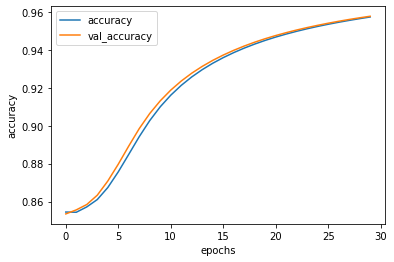

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string],'')
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
plot_graphs(history,'accuracy')

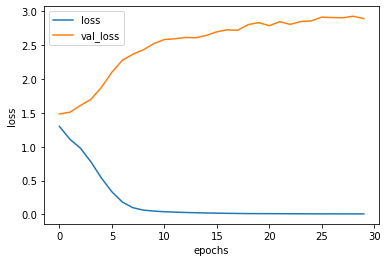

In [18]:
plot_graphs(history,'loss')
# 뭔가 잘못 됐다.


In [19]:
index_targets

array([[ 5589, 16582,  6525, ...,     0,     0,     0],
       [10873,   978,     2, ...,     0,     0,     0],
       [ 8247, 14568,  2334, ...,     0,     0,     0],
       ...,
       [20001,     2,     0, ...,     0,     0,     0],
       [ 3095, 12893, 12049, ...,     0,     0,     0],
       [11478,  2067,  3180, ...,     0,     0,     0]])

In [21]:
index_inputs

array([[10783,   431,     0, ...,     0,     0,     0],
       [10125, 19951,  8197, ...,     0,     0,     0],
       [20279, 15785, 15067, ...,     0,     0,     0],
       ...,
       [15411,  6804, 14281, ...,     0,     0,     0],
       [ 7826,  8927, 14911, ...,     0,     0,     0],
       [12021,  2569,     0, ...,     0,     0,     0]])